# 第4回 関数、行列、最適化

ライブラリnumpy、scipyを使って、さまざまな数値計算を行う。
ファイナンスの問題としてはインプライドボラティリティの導出とポートフォリオの最適化を行う。

## 関数

同じ処理を何度も繰り返すときは、処理を関数化すると便利である。
Pythonでは関数はつぎの書式で定義する。
```
def 関数名(引数):
  関数の処理
```
関数の処理のブロックは字下げをして記述する。
返り値をもつ関数の場合は、関数の処理の最後に`return 返り値`と記述する。

つぎの2つの関数は似たような振る舞いをする。

In [1]:
def squared1(x):
  print(x**2)

In [2]:
def squared2(x):
  return x**2

In [3]:
squared1(3)

9


In [4]:
squared2(3)

9

ただし、関数`squared1`は返り値を持たないので、つぎの計算はできない。

In [5]:
print(2 * squared1(3))

9


TypeError: ignored

返り値を持つ関数`squared2`であれば計算可能。

In [6]:
print(2 * squared2(3))

18


引数は複数あってもよい。

In [7]:
def quad1(x, a, b, c):
  return a * x**2 + b * x + c

In [8]:
quad1(1, 1, 2, 3)

6

つぎのように書くこともできる。関数の用途によって使い分ける。

In [9]:
a = 1
b = 2
c = 3
def quad2(x):
  return a * x**2 + b * x + c

In [10]:
quad2(1)

6

## 方程式の解
[Scipyライブラリ](https://scipy.org/)を用いて、方程式

$$
f(x) = 0  \tag{1}
$$

の解を求める。解を求めるアルゴリズムに応じた関数を用いることができる。
詳細は[https://docs.scipy.org/doc/scipy/tutorial/optimize.html#root-finding](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#root-finding)
を参照のこと。

Scipyは線形代数、微分、積分、最適化などさまざまな数値計算を行うためのライブラリである。ScipyではNumpy配列が基本的なデータ型になる。

Newton-Raphson法を用いて(1)の解を求めるには、`scipy.optimize`モジュールの`newton`関数を用いる。

In [11]:
import scipy.optimize as sco

2次方程式 $2x^2  - 5x - 4 = 0$ の解を求めてみる。上で定義した関数`quad1`を使おう。

In [12]:
root1 = sco.newton(quad1, 0, args=(2, -5, -4))

In [13]:
print(f'{root1:.3f}')

-0.637


`sco.newton`の2つ目の引数はNewton法により解を探す際の初期点である。
初期点を $x＝5$ にしたときの解を求めてみよ。

In [14]:
root2 = sco.newton(quad1, 5, args=(2, -5, -4))

In [15]:
print(f'{root2:.3f}')

3.137


解が複数ある場合には初期点により得られる解が変わる（初期点に近い解が見つかる）。グラフにより解と初期点の位置を確認するとよい。

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

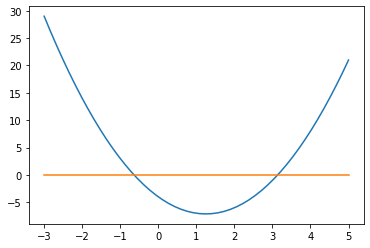

In [17]:
x = np.linspace(-3, 5, 50)
plt.plot(x, quad1(x, 2, -5, -4))
plt.plot(x, np.zeros(len(x)))


## インプライドボラティリティ
Black-Scholes公式は、原資産価格$S_0$、権利行使価格$K$、満期までの時間$T$、無リスク金利$r$、原資産のボラティリティ$\sigma$が与えられたときに、オプション価格$p$を与える式である。BS公式は$T$時点の原資産価格がつぎの確率変数で与えられることを前提としていた。

$$
S(T) = S_0 \exp\left\{\left(r - \frac{\sigma^2}{2}\right)T + \sigma \sqrt{T} z\right\}
$$

$S_0, K, T, r$とオプション価格$p$が与えられたとき、BS公式を満たす$\sigma$を**インプライドボラティリティ**と呼ぶ。BS公式は実際にはインプライドボラティリティを求めるための公式として使われる。

$S_0, K, T, r$は契約上決まっている値と市場で観察できる値であるため、いずれも推定を必要としない。BS公式を前提とすれば、オプション価格$p$を推定することとボラティリティ$\sigma$を推定することは同じことになる。

オプションの市場価格からインプライドボラティリティを求めてみよう。まず、コールオプションに対するBlack-Scholes公式を関数化する。

In [19]:
from scipy.stats import norm

def BScall(sigma, S, K, T, r):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

$S=100, K=99, T=1, r=0.01, \sigma=0.2$のとき、コールオプションの価格は約$8.91$であった。

In [20]:
print(f'{BScall(0.2, 100, 99, 1, 0.01):.3f}')

8.919


インプライドボラティリティを計算するため、つぎの関数を定義する。

In [22]:
def IV(sigma, price, S, K, T, r):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C - price

$S=100, K=99, T=1, r=0.01$かつコールオプションの価格が$8.919$のとき、インプライドボラティリティが$0.2$になるか確認してみる。

In [23]:
res = sco.newton(IV, 0.2, args=(8.919, 100, 99, 1, 0.01))

In [24]:
print(f'{res:.3f}')

0.200


確かに逆算されている。

実際のオプションの市場価格からインプライドボラティリティを計算してみる。つぎのセルに定義されている2次元のタプル`calldata`は原資産を日経225とするコールオプションの市場データである。
最初の列から順に

オプション価格$p$、原資産価格$S_0$, 権利行使価格$K$, 満期までの時間$T$, 無リスク金利$r$

を表す。29銘柄分のデータが含まれる。この29銘柄のインプライドボラティリティを求めてみる。

In [25]:
calldata = ((3.0, 26848.0, 32250.0, 0.108, 0.0),
 (5.0, 26848.0, 32000.0, 0.108, 0.0),
 (9.0, 26848.0, 31500.0, 0.108, 0.0),
 (10.0, 26848.0, 31250.0, 0.108, 0.0),
 (15.0, 26848.0, 31000.0, 0.108, 0.0),
 (20.0, 26848.0, 30750.0, 0.108, 0.0),
 (31.0, 26848.0, 30500.0, 0.108, 0.0),
 (39.0, 26848.0, 30250.0, 0.108, 0.0),
 (51.0, 26848.0, 30000.0, 0.108, 0.0),
 (51.0, 26848.0, 29875.0, 0.108, 0.0),
 (70.0, 26848.0, 29750.0, 0.108, 0.0),
 (70.0, 26848.0, 29500.0, 0.108, 0.0),
 (84.0, 26848.0, 29375.0, 0.108, 0.0),
 (135.0, 26848.0, 29250.0, 0.108, 0.0),
 (125.0, 26848.0, 29125.0, 0.108, 0.0),
 (160.0, 26848.0, 29000.0, 0.108, 0.0),
 (145.0, 26848.0, 28875.0, 0.108, 0.0),
 (180.0, 26848.0, 28750.0, 0.108, 0.0),
 (215.0, 26848.0, 28625.0, 0.108, 0.0),
 (280.0, 26848.0, 28500.0, 0.108, 0.0),
 (255.0, 26848.0, 28375.0, 0.108, 0.0),
 (305.0, 26848.0, 28250.0, 0.108, 0.0),
 (335.0, 26848.0, 28125.0, 0.108, 0.0),
 (460.0, 26848.0, 28000.0, 0.108, 0.0),
 (520.0, 26848.0, 27750.0, 0.108, 0.0),
 (580.0, 26848.0, 27500.0, 0.108, 0.0),
 (790.0, 26848.0, 27250.0, 0.108, 0.0),
 (780.0, 26848.0, 27125.0, 0.108, 0.0),
 (880.0, 26848.0, 27000.0, 0.108, 0.0))

In [26]:
calldata[1]

(5.0, 26848.0, 32000.0, 0.108, 0.0)

In [27]:
N = len(calldata)  # 銘柄数
res_IV = np.zeros(N) # 推定したインプライドボラティリティを格納する変数
strike = np.zeros(N) # 権利行使価格を格納する変数

for i in range(N):
  res_IV[i] = sco.newton(IV, 0.2, args=calldata[i])
  strike[i] = calldata[i][2]

権利行使価格`strike`とインプライドボラティリティ`res_IV`の関係を表すグラフを描く。

Text(0, 0.5, 'impllied vol')

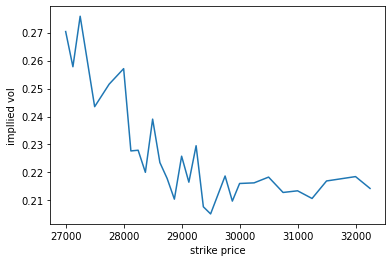

In [28]:
plt.plot(strike, res_IV)
plt.xlabel('strike price')
plt.ylabel('impllied vol')

BS公式が正しければ、権利行使価格$K$の値に関わらず、ボラティリティ$\sigma$の値は一定になるはずである。しかし、市場で観測されるインプライドボラティリティは上のグラフのような形状になることが多い。このボラティリティスマイルはBlack-Scholesモデルが市場と整合的でないことの証拠の一つである。

どのようなモデルを仮定すれば、このようなボラティリティスマイルが得られるかという問題がある。

## 行列計算

Numpyライブラリを用いて、行列の計算を復習する。

### ベクトルと行列

$n$ 個の数を縦に並べたものをベクトルとよぶ:

$$
a = 
 \begin{pmatrix}
  a_1\\
  a_2\\
  \vdots\\
  a_n
 \end{pmatrix}.
$$

これを $n$ 次元ベクトルとよび，$i$ 番目の数 $a_i$ をベクトル $a$ の第
$i$ 成分とよぶ．

いくつかの数字を縦と横に並べて一組としたものを**行列**とよぶ。
例えば、

$$
 \begin{pmatrix}
  0 & 1\\
  2 & 3
 \end{pmatrix}\quad \text{や}\quad
 \begin{pmatrix}
  1 & 2 & 3\\ 
  4 & 5 & 6
 \end{pmatrix}
$$

のようなものである。
いま、$m \times n$ 個の数字 $a_{ij}$ 
($i = 1, 2, \dots, m$, $j = 1, 2, \dots ,n$) を縦と横に並べて作った行列

$$
 A = 
  \begin{pmatrix}
   a_{11} & a_{12} & \cdots & a_{1n}\\
   a_{21} & a_{22} & \cdots & a_{2n}\\
   \vdots & \vdots & \vdots & \vdots \\
   a_{m1} & a_{m2} & \cdots & a_{mn}
  \end{pmatrix}
$$

を考える。
行列の横の並びを**行**、縦の並びを**列**とよぶ。
また、対角線上並んだ成分 ($a_{11}, a_{22}, \dots$) を対角成分とよぶ。
行列$A$には 
$m$行、$n$列あるので、これを $m \times n$ 行列とよび、$m \times n$ を
行列の大きさ(サイズ)とよぶ。
行列の上から $i$ 番目、左から $j$ 番目の数を 
$(i, j)$ 成分という。
行列$A$を $A = (a_{ij})$ と表記することもある。
これは $A$ が $(i, j)$ 成分に $a_{ij}$ をもつ行列であることを表現している。

ベクトルも行列の一種である。行が 1 つの行列が行ベクトル、列が 1 つの行列
が列ベクトルである。

### 行列の転置
$m \times n$ 行列 $A = (a_{ij})$ において、行と列を入れ替えること、すなわち $(i, j)$ 成分と $(j, i)$ 成分を入れ替えることを、
行列を**転置**するといい、転置された行列を$A^{\top}$ と書く。
転置された行列を**転置行列**とよぶ。
転置行列 $A^{\top}$ は $n \times m$ 行列になる．
例えば，

$$
\begin{equation*}
A = 
 \begin{pmatrix}
  1 & 2 & 3\\
  4 & 5 & 6
 \end{pmatrix}
\end{equation*}
$$

のとき，

$$
\begin{equation*}
A^{\top} = 
 \begin{pmatrix}
  1 & 4\\
  2 & 5\\
  3 & 6
 \end{pmatrix}
\end{equation*} 
$$

となる．

Numpyでは転置は`.T`により計算する。

In [29]:
A = np.array([[1, 2, 3],
             [4, 5, 6]])
print(A)
print(A.T)

[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]


### 行列の和
$m \times n$ 行列$A = (a_{ij})$，$B = (b_{ij})$ を考える．$A$，$B$ の
すべての成分に対して，$a_{ij} = b_{ij}$ が成り立つとき，$A = B$ であると
定義する．
行列の和，差，実数(スカラー)倍をつぎのように定義する．

$$
\begin{align}
 A + B &= (a_{ij} + b_{ij})\quad \text{[成分ごとの和]}\\
 A - B &= (a_{ij} - b_{ij})\quad \text{[成分ごとの差]}\\
 cA & = (ca_{ij})\ (c \text{は実数})\quad \text{[各成分を実数倍]}．
\end{align}
$$

異なる大きさをもつ行列の和と差は定義できないことに注意する．

**例**

$$
 A =
  \begin{pmatrix}
   1 & 0 \\
   2 & 3
  \end{pmatrix},\quad
 B =
 \begin{pmatrix}
  -1 & 2 \\
  3 & 5
 \end{pmatrix}
$$

のとき

$$
 A + B =
  \begin{pmatrix}
   0 & 2 \\
   5 & 8
  \end{pmatrix},\quad
 A - B =
 \begin{pmatrix}
  2 & -2 \\
  -1 & -2
 \end{pmatrix},\quad
 2A = 
 \begin{pmatrix}
  2 & 0\\
  4 & 6
 \end{pmatrix}
$$

となる．

これらの定義から行列の和と差に関しては実数と同じように、交換法則 ($A + B
= B + A$) と結合法則($(A + B) + C = A + (B + C)$) が成り立つことが分かる。
また、

$$
 (A + B)^{\top} = A^{\top} + B^{\top},\quad
  (cA)^{\top} = cA^{\top}\quad (c \text{は実数})
$$

が成り立つことも確認できる。

In [30]:
A = np.array([[1, 0],
             [2, 3]])
B = np.array([[-1, 2],
              [3, 5]])
print(A)
print(B)

[[1 0]
 [2 3]]
[[-1  2]
 [ 3  5]]


In [31]:
print(A + B)
print(A - B)
print(2*A)

[[0 2]
 [5 8]]
[[ 2 -2]
 [-1 -2]]
[[2 0]
 [4 6]]


### 行列の積

$m \times n$ 行列 $A = (a_{ij})$ と $n \times l$ 行列 $B = (b_{ij})$
の積をつぎのように定義する。

$$
 AB =
  \begin{pmatrix}
   \sum_{k=1}^{n}a_{1k}b_{k1} & \sum_{k=1}^{n}a_{1k}b_{k2} & \cdots
   & \sum_{k=1}^{n}a_{1k}b_{kl}\\
   \sum_{k=1}^{n}a_{2k}b_{k1} & \sum_{k=1}^{n}a_{2k}b_{k2} & \cdots
   & \sum_{k=1}^{n}a_{2k}b_{kl}\\
   \vdots & \vdots & \vdots & \vdots \\
   \sum_{k=1}^{n}a_{mk}b_{k1} & \sum_{k=1}^{n}a_{mk}b_{k2} & \cdots
   & \sum_{k=1}^{n}a_{mk}b_{kl}\\
  \end{pmatrix}．
$$

行列 $A$，$B$ の積 $AB$ は $m \times l$ 行列になる。
また、行列の積は **$A$ の列数と $B$ の行数が同じのときにのみ**定義されることに注意せよ。
例えば、$2 \times 3$行列と$3 \times 2$行列の積は

$$
 \begin{pmatrix}
  a_{11} & a_{12} & a_{13}\\
  a_{21} & a_{22} & a_{23}\\
 \end{pmatrix}
 \begin{pmatrix}
  b_{11} & b_{12}\\
  b_{21} & b_{22}\\
  b_{31} & b_{32}
 \end{pmatrix}
 =
 \begin{pmatrix}
  a_{11}b_{11} + a_{12}b_{21} + a_{13}b_{31} &
  a_{11}b_{12} + a_{12}b_{22} + a_{13}b_{32}\\
  a_{21}b_{11} + a_{22}b_{12} + a_{23}b_{31} &
  a_{21}b_{12} + a_{22}b_{22} + a_{23}b_{32}
 \end{pmatrix}
$$

となる。

行列の積については，定義から結合法則 ($(AB)C = A(BC)$) と
分配法則 ($A(B + C) = AB + AC$, $(B + C)A = BA + CA$) は成り立つが、
**交換法則 ($AB = BA$)は成り立たない**。
$AB$ が定義できたとしても $BA$ が定義できないこともある。

Numpyでは行列の積は`np.dot(A, B)`によって計算する（`A * B`ではないので注意する）。

In [32]:
print(np.dot(A, B))
print(np.dot(B, A))


[[-1  2]
 [ 7 19]]
[[ 3  6]
 [13 15]]


### ベクトルの内積
ベクトルについて

$$
 a =
  \begin{pmatrix}
   a_1\\ a_2\\ \vdots \\ a_n
  \end{pmatrix},\
 b =
  \begin{pmatrix}
   b_1\\ b_2\\ \vdots \\ b_n
  \end{pmatrix}
$$

について $a^{\top}b$ は行列$a^{\top}$ と行列 $b$ の行列の積であるので、定義にしたがって計算すると、

$$
 a^{\top}b = 
  \begin{pmatrix}
   a_1 & a_2 & \cdots & a_n
  \end{pmatrix}
  \begin{pmatrix}
   b_1\\
   b_2\\
   \vdots\\
   b_n
  \end{pmatrix}
= a_1b_1 + a_2b_2 + \dots + a_nb_n
$$

となる。これをベクトルの**内積**と呼ぶ。

In [33]:
a = np.array([1, 2, 3]).reshape(-1, 1)
b = np.array([4, 5, 6]).reshape(-1, 1)
print(a)
print(b)

[[1]
 [2]
 [3]]
[[4]
 [5]
 [6]]


1次元のNumpy配列に対してメソッド`.reshape(-1, 1)`とすることで、列数が1のベクトル、すなわち列ベクトルに変換している。1次元のNumpy配列は行と列の概念を持たないので、ベクトルを扱う際には`.reshape(-1, 1)`をしたほうがよい。

In [34]:
np.dot(a.T, b)

array([[32]])

### 逆行列
$n$ 次**正方行列**（行数と列数が同じ行列） $A$ に対して、

$$
  XA = AX = I
$$

を満たす正方行列 $X$ を $A$ の逆行列といい、$X$ を $A^{-1}$ と書く。
ここで、$I$ は単位行列。

連立方程式
$$
Ax = b
$$
について、$A^{-1}$が存在すれば、その解は
$x = A^{-1}b$
となる。

連立方程式

$$
  \begin{cases}
   x + 2y - 3z = 3\\
   3x + y + z = 9\\
  -2x + y - z = 0
  \end{cases}
$$

を解く。

$$
A = 
\begin{pmatrix}
1 & 2 & -3\\
3 & 1 & 1\\
-2 & 1 & -1
\end{pmatrix},\ 
b = 
\begin{pmatrix}
3\\
9\\
0
\end{pmatrix}
$$

として、
$x = A^{-1}b$
を計算すればよい。

Numpyでは逆行列は `linalg.inv()`関数によって計算できる。

In [36]:
A = np.array([[1, 2, -3],
              [3, 1, 1],
              [-2, 1, -1]])
b = np.array([3, 9, 0]).reshape(-1, 1)

invA = np.linalg.inv(A)
x = np.dot(invA, b)
print(x)

[[1.]
 [4.]
 [2.]]


## 最適化
何らかの制約条件のもとで関数を最大化もしくは最小化する方法を考える。
制約条件の有無、制約条件の形、目的関数の種類に応じて、
さまざまな最適化手法が存在する。

まず、非線形な関数$f(x)$に関して、制約なしの最小化問題

$$
\min_x f(x) \tag{2}
$$

を考える。$x$は1変数でも、多変数でもよい。
最適化理論では最大化、最小化のどちらを考えてもよい。
関数 $f(x)$ を最大にするには，$-f(x)$ を最小にすればよいので、どちらか一
方だけ考えておけば理論的には十分である。ここでは最小化問題を考える。

1変数関数の場合、(2)の解が$x=a$のとき、

$$
f'(a) = 0 
$$

を満たす。しかし、$f'(a) = 0$ だからといって、$x=a$で最小値をとるとは限らない。$f'(a)=0$となる$x=a$の前後で$f'(x)$の符号がマイナスからプラスに変わるとき、$f(x)$は$x=a$で**極小値**をとるという。

$f(x)$が**凸関数**のときは、$x=a$で極小値を取ることと最小値を取ることは同値となる。すなわち、最小値を求めるためには極小値を探す、大雑把に言えば$f'(a)=0$となる $x=a$ を探せばよい。しかし、$f(x)$が非凸関数である場合には、極小値が最小値になるとは限らないので注意する。

例として、関数 $f(x) = \sin(x) + \frac{1}{20}x^2$ （非凸関数）の最小化を考えよう。

In [37]:
def f(x):
  return np.sin(x) + 0.05 * x**2

グラフを描いてみる。

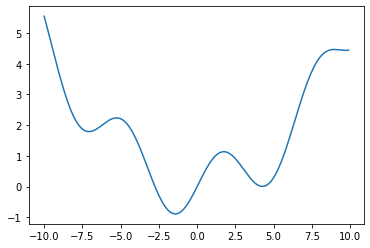

In [38]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, f(x))

$x=-1$の付近に最小解がありそうである。

scipy.optimizeモジュールの `minimize`関数により最小化を行う。
`minimize()`の2つ目の引数で最小解を探す際の初期点を指定する。
`minimize()`関数の詳細は
[https://docs.scipy.org/doc/scipy/tutorial/optimize.html#](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#)
を参照せよ。

In [39]:
res_opt = sco.minimize(f, 0)
print(res_opt)

      fun: -0.8878628265737075
 hess_inv: array([[0.9177531]])
      jac: array([7.4505806e-09])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([-1.42755179])


よって、$x=-1.306$ で最小値を取る。最小解は `res_opt.x` によって取り出すことができる。


**演習問題**
初期点を $x=4$ としたときの最小解を求めよ。

In [40]:
res_opt2 = sco.minimize(f, 4)
print(res_opt2)

      fun: 0.00791287635367166
 hess_inv: array([[0.99929242]])
      jac: array([-4.92483377e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.27109043])


最小解ではない極小解が求められている。このように、非凸な関数の最適解を求める際には、初期点の選び方が重要な役割を果たす。

多変数関数 $f(x)$　の場合は勾配ベクトルがゼロになる点

$$
\nabla f(x) = 0
$$

を求めればよい。

2変数関数

$$
f(x,y)=\sin(x)+\frac{1}{20}x^2 + \sin(y) + \frac{1}{20}y^2
$$

の最小化を行う（参考書11.2節）。

In [41]:
def fo(p):
  return np.sin(p[0]) + 0.05 * p[0]**2 + np.sin(p[1]) + 0.05 * p[1]**2

In [42]:
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = fo((X, Y))

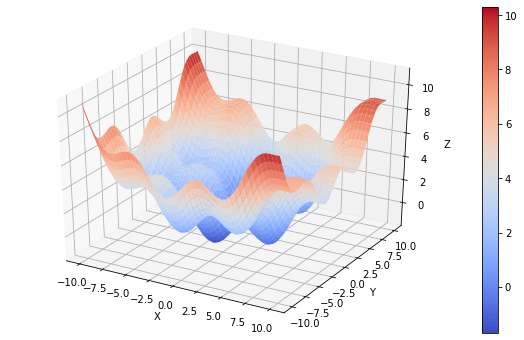

In [43]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf)

初期点を$(0,0)$として解を探してみる。

In [44]:
x0 = np.array([0, 0])
res_opt3 = sco.minimize(fo, x0)

In [45]:
res_opt3

      fun: -1.7757256531462606
 hess_inv: array([[ 0.95909952, -0.04090049],
       [-0.04090049,  0.95909951]])
      jac: array([1.13248825e-06, 1.13248825e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-1.42755075, -1.42755075])

**演習問題** 
初期点を$(5,5)$とした場合の解を求めてみよ。

In [46]:
x0 = np.array([5, 5])
res_opt4 = sco.minimize(fo, x0)
print(res_opt4)

      fun: 0.015825752691759787
 hess_inv: array([[ 0.9962716, -0.0037284],
       [-0.0037284,  0.9962716]])
      jac: array([2.94297934e-06, 2.94297934e-06])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.27109826, 4.27109826])


## ポートフォリオの最適化（Markowitzの平均分散アプローチ、制約条件付き最適化）

$N$資産に分散投資をするポートフォリオの最適化を考える。
投資比率を

$$
\phi=
\begin{pmatrix}
  \phi_1\\
  \phi_2\\
  \dots\\
  \phi_N
\end{pmatrix}
$$

とおく。$\phi$は投資比率なので

$$
\sum_{i=1}^N\phi_i = \phi^T\mathbf{1} = 1
$$

を満たす。ここで $\mathbf{1}$はすべての要素が1の$N$次元ベクトルである。
さらに、$N$資産の期待収益率を$r$（ベクトル）、分散共分散行列を$\Sigma$とする。
すると、ポートフォリオの期待収益率は

$$
\sum_{i=1}^N\phi_ir_i = \phi^T r
$$

分散は

$$
\phi^T \Sigma \phi
$$

と計算できる。

目標収益率を$\mu$とすると、平均分散アプローチでは以下の最適問題を解いて、
最適ポートフォリオ$\phi$を求める。

$$ 
\begin{cases}
\min_{\phi} &\phi^T \Sigma \phi \ \text{（3）}\\
\text{s.t.} &\phi^T r = \mu,\ \phi^T \mathbf{1} =1
\end{cases}
$$

この最適化問題をscipy.optimizeモジュールのminimize関数を使って解いてみよう。

前回の講義で用いた株価データ `sample1.csv` の3銘柄について、期待収益率と分散共分散行列を求めると、つぎのようになる（詳細は付録を参照）。

In [47]:
means = np.array([0.0203, 0.0116, 0.0109]).reshape(-1, 1)
cov = np.array([[0.00496, 0.00298, 0.00138],
               [0.00298, 0.00702, 0.00112],
               [0.00138, 0.00112, 0.00275]])

例えば、投資比率$\phi = (0.2, 0.3, 0.5)^T$というポートフォリオの期待収益率と分散はつぎのように計算できる。

In [48]:
weights = np.array([0.2, 0.3, 0.5]).reshape(-1, 1)  #投資比率
print(np.dot(weights.T, means)) #期待収益率
print(np.dot(weights.T, np.dot(cov, weights))) #分散

[[0.01293]]
[[0.0024873]]


では、(3)を解いていく。
まず、制約条件を表す関数を定義する。

In [50]:
def const1(weights): # 目標収益率に関する制約条件
  return np.dot(weights.T, means) - target_ret

def const2(weights): # 投資比率の合計が1である制約条件
  return np.sum(weights) - 1

目的関数を定義する。

In [51]:
def port_vol(weights):
  return np.dot(weights.T, np.dot(cov, weights))

最適化の実行。目標収益率を$0.05$に設定する。

In [53]:
cons = ({'type': 'eq', 'fun': const1},
        {'type': 'eq', 'fun': const2})
target_ret = 0.05

res = sco.minimize(port_vol, [0.1, 0.5, 0.4], constraints=cons)

結果の表示

In [54]:
print(res)

     fun: 0.066097491606704
     jac: array([ 0.02951634,  0.00080428, -0.00165975])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 4.41308126, -1.51291355, -1.90016771])


最適ポートフォリオは$(4.41, -1.51, -1.90)$、分散は$0.066$となる。

効率的フロンティアを描く。

In [55]:
ret = np.linspace(0.001, 0.04, 50) #目標収益率の列
min_var = np.zeros(len(ret))  #最小分散を入れる変数

i = 0
for target_ret in ret:
  res = sco.minimize(port_vol, [0.3, 0.3, 0.4], constraints=cons)
  min_var[i] = res.fun
  i += 1

In [56]:
print(ret)
print(min_var)

[0.001      0.00179592 0.00259184 0.00338776 0.00418367 0.00497959
 0.00577551 0.00657143 0.00736735 0.00816327 0.00895918 0.0097551
 0.01055102 0.01134694 0.01214286 0.01293878 0.01373469 0.01453061
 0.01532653 0.01612245 0.01691837 0.01771429 0.0185102  0.01930612
 0.02010204 0.02089796 0.02169388 0.0224898  0.02328571 0.02408163
 0.02487755 0.02567347 0.02646939 0.02726531 0.02806122 0.02885714
 0.02965306 0.03044898 0.0312449  0.03204082 0.03283673 0.03363265
 0.03442857 0.03522449 0.03602041 0.03681633 0.03761224 0.03840816
 0.03920408 0.04      ]
[0.00856153 0.00773529 0.0069672  0.00625725 0.00560545 0.0050118
 0.0044763  0.00399894 0.00357973 0.00321867 0.00291575 0.00267098
 0.00248436 0.00235588 0.00228555 0.00227386 0.00231953 0.00242389
 0.00258614 0.00280652 0.00308506 0.00342174 0.00381657 0.00426954
 0.00478066 0.00534993 0.00597735 0.00666291 0.00740662 0.00820848
 0.00906849 0.00998664 0.01096294 0.01199739 0.01308999 0.01424073
 0.01544962 0.01671665 0.01804184 0.0194

matplotlibを使ってグラフを描く

Text(0, 0.5, 'expected return')

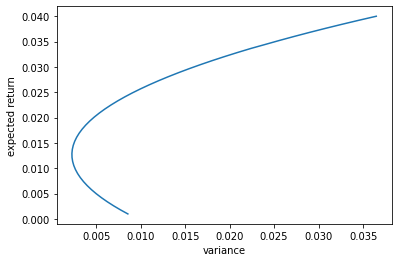

In [57]:
plt.plot(min_var, ret)
plt.xlabel('variance')
plt.ylabel('expected return')